<a href="https://colab.research.google.com/github/chunyuan0221/3rd-ML100days/blob/master/Day_076_optimizer_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

### ANS:
1. 以Adam為例，調整 batch_size, epoch, 觀察accurancy, loss 的變化  
Ans:
    - batch_size: Accurancy會隨著batch_size的變大而上升  
    - epoch:
        1. 如果單純只看train的結果Accuracy會隨著epoch變大而提升
        2. 但如果是看驗證(validation)的結果並不會隨著epoch的變大而上升。ex:發生的情況像是model已經overfitting，訓練結果會一直提升，但驗證結果到了一定的值後卻不會提升。
    
    
2. 不同optimizer對accurancy的影響  
Ans:
    - SGD:需要較多的epoch才會使驗證結果收斂。隨著epoch在訓練上的提升，採用SGD會使訓練結果和驗證結果
    - Adam:相對SGD用少量的epoch驗證結果就已經收斂，但訓練結果仍不斷上升
    - RMSprop:與Adam類似，同樣可以用較少的epoch將驗證結果收斂，但沒有Adam穩定
***
- SGD acc:

![SGD](https://drive.google.com/uc?id=1d4SnHm08CU6qZX5zr6mPqqN0ZTSL9nu5)

- Adam acc:

![Adam](https://drive.google.com/uc?id=13XqtA21yu2FVw5gMdbF_t4nMIPlz4Fkq)

- RMSprop acc:

![RMSprop](https://drive.google.com/uc?id=1gPbxWr6TFwG8hbArUrCU0iF2U21wUDXf)

In [0]:
from google.colab import files
#file = files.upload()

# 作業目標:
    
    取得各種優化器的運算結果

In [2]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers

import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


In [0]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [0]:
# 宣告並設定 : 
# batch_size：對總的樣本數進行分組，每組包含的樣本數量
# epochs ：訓練次數

batch_size = 100
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [0]:
# load the cifar10 dataset
def load_cifar():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    print(f'Train shape: X={x_train.shape}, Y={y_train.shape}')
    print(f'Test shape: X={x_test.shape}, Y={y_test.shape}')
    y_train = keras.utils.to_categorical(y_train)
    y_test = keras.utils.to_categorical(y_test)
    print('After OneHotEncoding:')
    print(f'Train shape: X={x_train.shape}, Y={y_train.shape}')
    print(f'Test shape: X={x_test.shape}, Y={y_test.shape}')
    return x_train, y_train, x_test, y_test

In [0]:
# scale pixels
def pixel_scale(x_train, x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    train_norm = x_train/255.0
    test_norm = x_test/255.0
    return train_norm, test_norm

In [0]:
# create model function
def create_model(opt):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3),activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3),activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(128, (3, 3),activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    #compile
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#### load data and scale the data
- scale_pixel: 將0~255的色彩數值除以255，讓數值標準化到0、1之間，模型在收斂上會有更好的成果

In [8]:
x_train, y_train, x_test, y_test = load_cifar()
x_train, x_test = pixel_scale(x_train, x_test)

Train shape: X=(50000, 32, 32, 3), Y=(50000, 1)
Test shape: X=(10000, 32, 32, 3), Y=(10000, 1)
After OneHotEncoding:
Train shape: X=(50000, 32, 32, 3), Y=(50000, 10)
Test shape: X=(10000, 32, 32, 3), Y=(10000, 10)


### Use different optimizer in model

In [9]:
'''
 SGD(隨機梯度下降) - Arguments
lr: float >= 0. Learning rate.
momentum: float >= 0. Parameter that accelerates SGD in the relevant direction and dampens oscillations.
decay: float >= 0. Learning rate decay over each update.
nesterov: boolean. Whether to apply Nesterov momentum.

RMSprop- Arguments
lr: float >= 0. Learning rate.
rho: float >= 0.
epsilon: float >= 0. Fuzz factor. If None, defaults to K.epsilon().
decay: float >= 0. Learning rate decay over each update.

Example:
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
'''

#opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = optimizers.Adam()
#opt = optimizers.RMSprop()
model = create_model(opt)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [10]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1469994


In [11]:
# 輸出模型摘要資訊
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)         

In [12]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)   

#   第四步：訓練
#   .fit的一些參數
#   batch_size：對總的樣本數進行分組，每組包含的樣本數量
#   epochs ：訓練次數
#   shuffle：是否把數據隨機打亂之後再進行訓練
#   validation_split：拿出百分之多少用來做交叉驗證
#   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果   

Using real-time data augmentation.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/20




50000/50000 [==============================] - 10s 192us/step - loss: 1.7442 - acc: 0.3461 - val_loss: 1.3712 - val_acc: 0.4855
Epoch 2/20
50000/50000 [==============================] - 7s 144us/step - loss: 1.2742 - acc: 0.5412 - val_loss: 1.0295 - val_acc: 0.6312
Epoch 3/20
50000/50000 [==============================] - 7s 137us/step - loss: 1.0570 - acc: 0.6266 - val_loss: 0.8912 - val_acc: 0.6844
Epoch 4/20
50000/50000 [==============================] - 7s 142us/step - loss: 0.9143 - acc: 0.6803 - val_loss: 0.8261 - val_acc: 0.7147
Epoch 5/20
50000/50000 [==============================] - 7s 138us/step - loss: 0.8321 - acc: 0.7103 - val_loss: 0.7740 - val_acc: 0.7328
Epoch 6/20
50000/50000 [==============================] - 7s 137us/step - loss: 0.7490 - acc: 0.7400 - val_loss: 0.7021 - v

In [13]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 1s 106us/step
Test loss: 0.6672406974315643
Test accuracy: 0.8008


In [14]:
# 第六步：輸出
import numpy 

print ( " test set " )
scores = model.evaluate(x_test,y_test,batch_size=200,verbose= 0)
print ( "" )
#print ( " The test loss is %f " % scores)
print ( " The test loss is %f ", scores)


result = model.predict(x_test,batch_size=200,verbose= 0)

result_max = numpy.argmax(result, axis = 1 )
test_max = numpy.argmax(y_test, axis = 1 )

result_bool = numpy.equal(result_max, test_max)
true_num = numpy.sum(result_bool)


 test set 

 The test loss is %f  [0.6672407013177871, 0.8008000004291534]


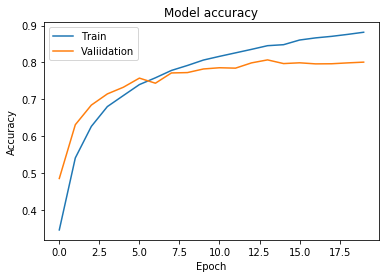

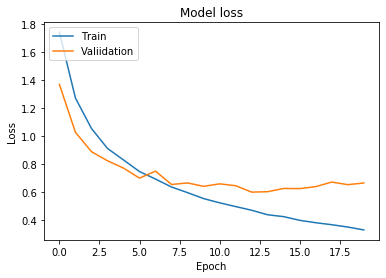

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valiidation'], loc='upper left')
plt.show()